In [1]:
import json
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.decomposition import TruncatedSVD

from tqdm.auto import tqdm
from pathlib import Path


In [2]:
N_COMPONENTS = 2
N_CLUSTERS = 10

In [3]:
def reduction_dim(dict_lex, n_components=4):
    dict_lex_reduced = {}
    for k, v in dict_lex.items():
        svd = TruncatedSVD(n_components=n_components)
        svd.fit(np.array([e[1] for e in v]))
        dict_lex_reduced[k] = [(e[0], svd.transform([e[1]])[0]) for e in v]
    return dict_lex_reduced


In [4]:
path = Path('explore_clusters')
path.mkdir(exist_ok=True)


In [5]:
with open('collection_textes.pickle', 'rb') as f:
    collection_textes = pickle.load(f)


In [6]:
alllex = [e.lexicalites for e in collection_textes]

allecarts = [e.ecarts for e in collection_textes]

In [7]:
dict_lex = {taile: [] for taile in range(1000)}
for i, lex in enumerate(alllex):
    dict_lex[len(lex)].append((i, lex))

dict_lex = {k: v for k, v in dict_lex.items() if v}

dict_ecarts = {taile: [] for taile in range(1000)}
for i, ecart in enumerate(allecarts):
    dict_ecarts[len(ecart)].append((i, ecart))

dict_ecarts = {k: v for k, v in dict_ecarts.items() if v}

In [8]:
dict_lex_sup_n_sub = {k: v for k, v in dict_lex.items() if N_COMPONENTS < k < 200}
dict_ecarts_sup_n_sub = {k: v for k, v in dict_ecarts.items() if N_COMPONENTS < k < 200}

In [9]:
dict_lex_reduced = reduction_dim(dict_lex_sup_n_sub, n_components=N_COMPONENTS)
dict_ecarts_reduced = reduction_dim(dict_ecarts_sup_n_sub, n_components=N_COMPONENTS)

/home/marceau/PycharmProjects/memoire/venv/lib64/python3.11/site-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
/home/marceau/PycharmProjects/memoire/venv/lib64/python3.11/site-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
/home/marceau/PycharmProjects/memoire/venv/lib64/python3.11/site-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
/home/marceau/PycharmProjects/memoire/venv/lib64/python3.11/site-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
/home/marceau/PycharmProjects/memoire/venv/lib64/python3.11/site-packages/sklearn/decomposition/_tru

In [10]:
liste_lex = [e for v in dict_lex_reduced.values() for e in v if len(e[1]) == 2]
liste_ecarts = [e for v in dict_ecarts_reduced.values() for e in v if len(e[1]) == 2]
combined = [(*e, *f) for e, f in zip(liste_lex, liste_ecarts)]

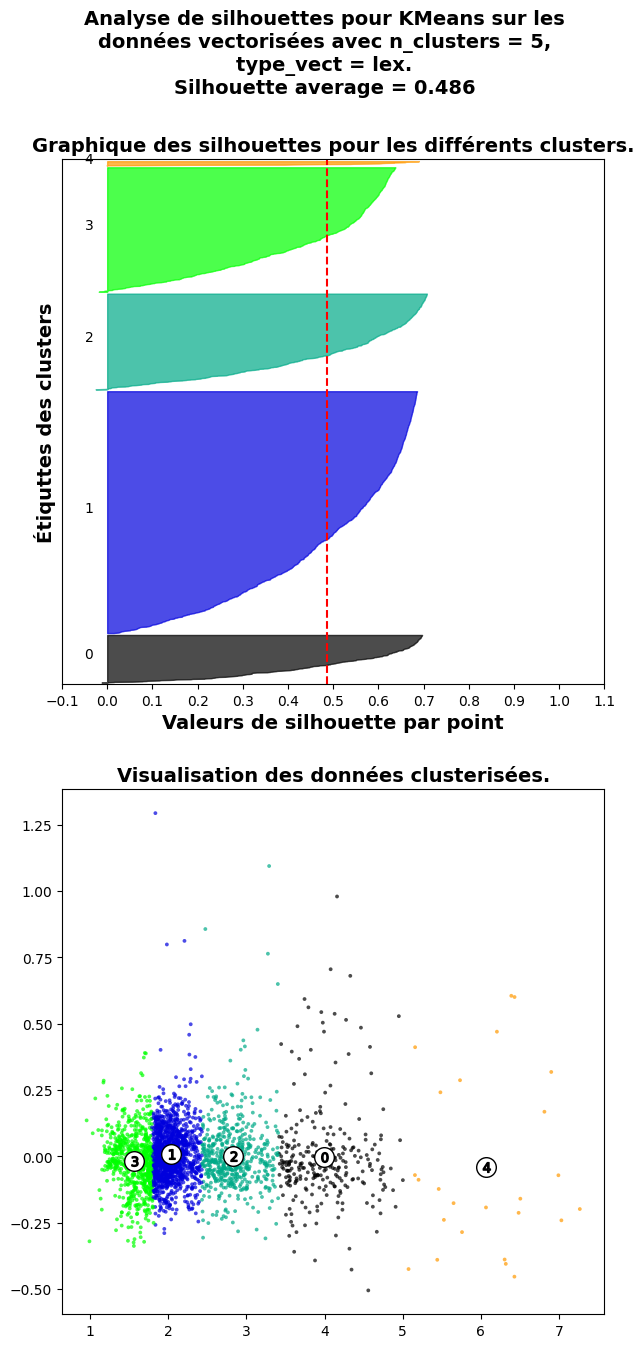

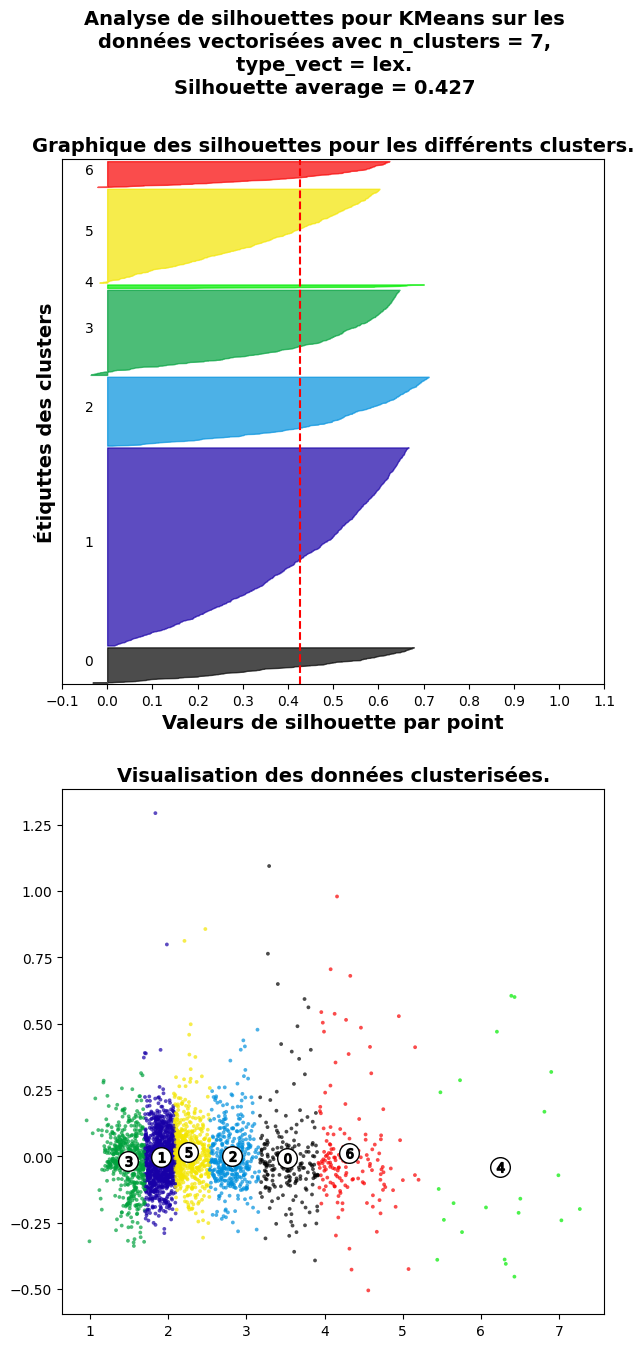

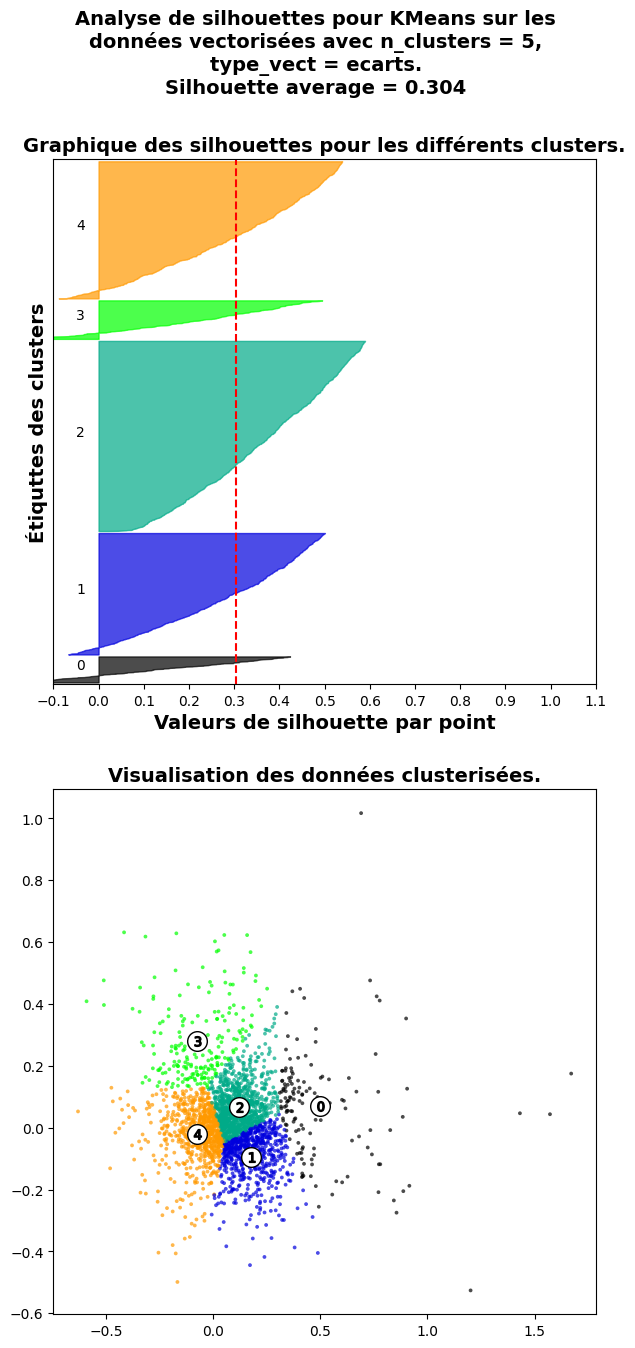

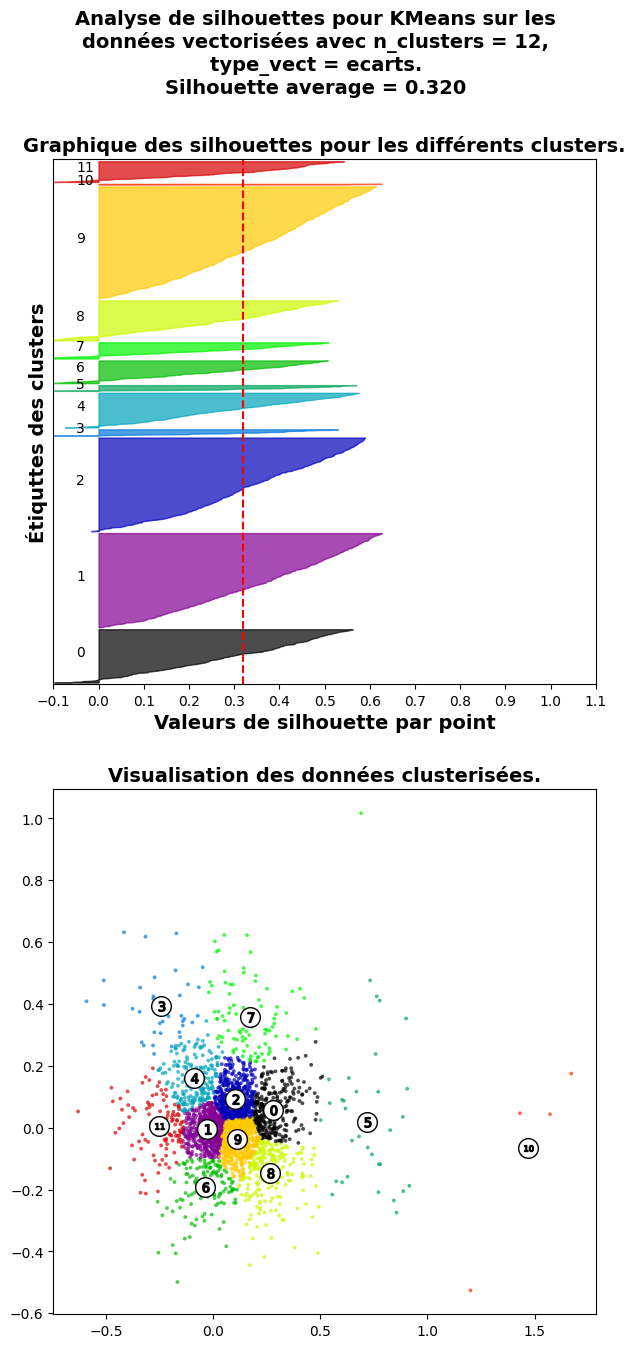

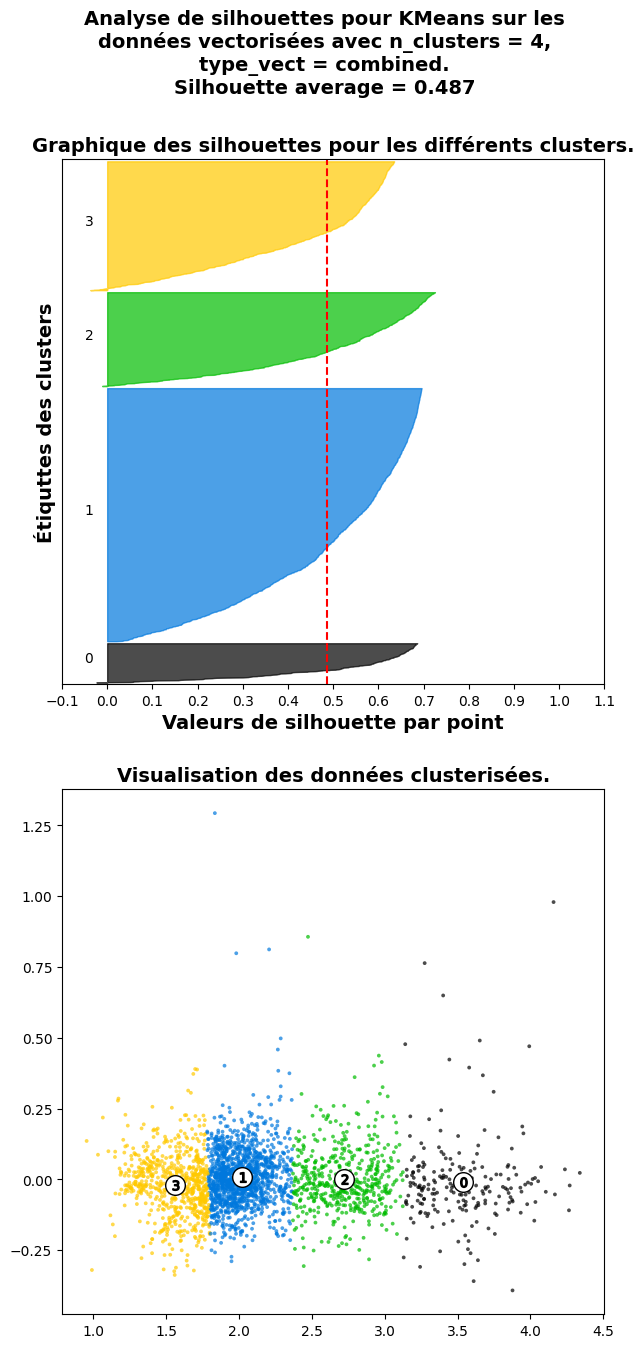

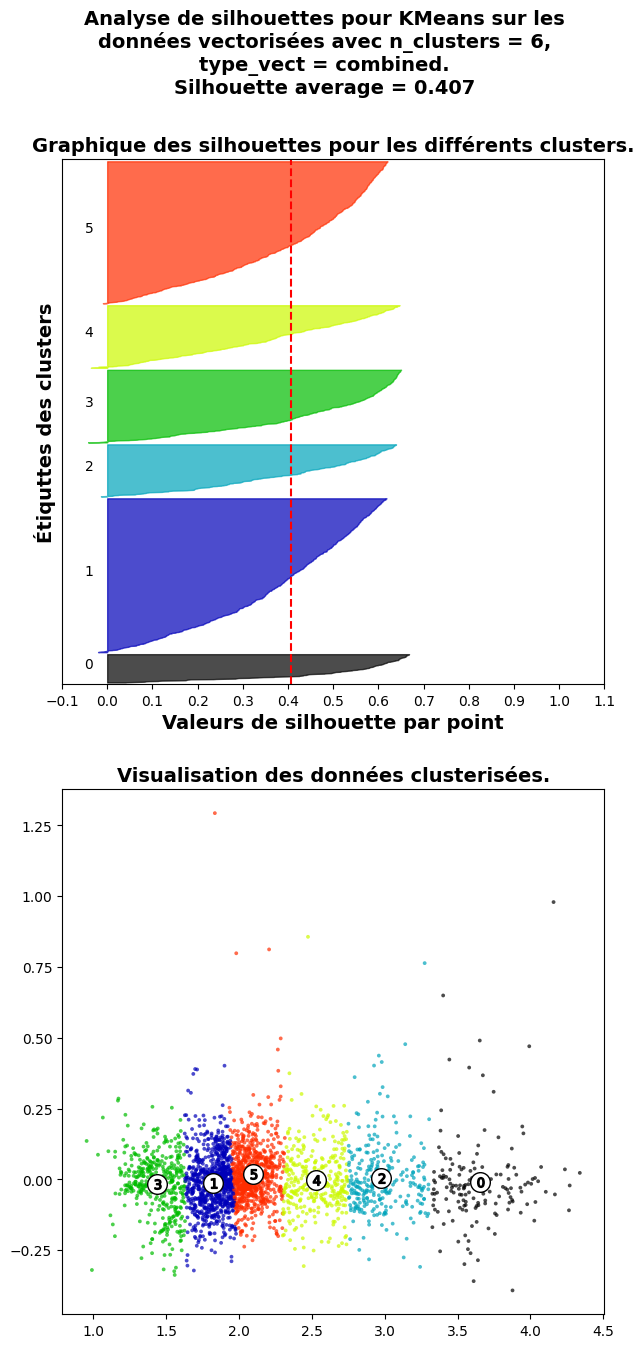

In [11]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

dict_vects = {
    "lex": liste_lex,
    "ecarts": liste_ecarts,
    "combined": combined
}

tests = (
    (5, "lex"),
    (7, "lex"),
    (5, "ecarts"),
    (12, "ecarts"),
    (4, "combined"),
    (6, "combined"),
)

clusters_dir = path / "clusters"
clusters_dir.mkdir(exist_ok=True, parents=True)
exemple_dir = path / "exemples"
exemple_dir.mkdir(exist_ok=True, parents=True)
silhouette_dir = path / "silhouette"
silhouette_dir.mkdir(exist_ok=True, parents=True)

for n_clusters, type_vect in tests:
    km = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    km.fit([e[1] for e in dict_vects[type_vect]])
    dict_clusters = {i: [] for i in range(n_clusters)}

    for i, e in enumerate(dict_vects[type_vect]):
        dict_clusters[km.labels_[i]].append(e[0])

    with open(clusters_dir / f"{type_vect}_{n_clusters}.json", "w") as f:
        json.dump(dict_clusters, f, indent=4, ensure_ascii=False)

    exemples = [
        (cluster, collection_textes[value[0]].header, collection_textes[value[0]].texte) for cluster, value in
        dict_clusters.items()
    ]

    with open(exemple_dir / f"{type_vect}_{n_clusters}.json", "w") as f:
        json.dump(exemples, f, indent=4, ensure_ascii=False)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(7, 15)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([
        0,
        len(
            dict_vects[type_vect]
        ) + (n_clusters + 1) * 10]
    )
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(
        [e[1] for e in dict_vects[type_vect]],
        cluster_labels
    )
    sample_silhouette_values = silhouette_samples(
        [e[1] for e in dict_vects[type_vect]],
        cluster_labels
    )
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[
                cluster_labels == i
                ]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        ax1.text(
            -0.05,
            y_lower + 0.5 * size_cluster_i,
            str(i)
        )

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(
        "Graphique des silhouettes pour les différents clusters.",
        fontsize=14,
        fontweight='bold'
    )

    ax1.set_xlabel(
        "Valeurs de silhouette par point",
        fontsize=14,
        fontweight='bold'
    )

    ax1.set_ylabel(
        "Étiquttes des clusters",
        fontsize=14,
        fontweight='bold'
    )

    ax1.axvline(
        x=silhouette_avg,
        color="red",
        linestyle="--"
    )

    ax1.set_yticks([])
    ax1.set_xticks(
        np.arange(
            -0.1,
            1.1,
            0.1
        )
    )

    colors = cm.nipy_spectral(
        cluster_labels.astype(float) / n_clusters
    )

    ax2.scatter(
        [e[1][0] for e in dict_vects[type_vect]],
        [e[1][1] for e in dict_vects[type_vect]],
        marker='.',
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor='k'
    )

    centers = km.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker='o',
        c="white",
        alpha=1,
        s=200,
        edgecolor='k'
    )

    for i, c in enumerate(centers):
        ax2.scatter(
            c[0],
            c[1],
            marker='$%d$' % i,
            alpha=1,
            s=50,
            edgecolor='k'
        )

    ax2.set_title(
        "Visualisation des données clusterisées.",
        fontsize=14,
        fontweight='bold'
    )

    plt.suptitle(
        (
            f"""Analyse de silhouettes pour KMeans sur les
données vectorisées avec n_clusters = {n_clusters},
type_vect = {type_vect}.
Silhouette average = {silhouette_avg :.3f}"""
        ),
        fontsize=14,
        fontweight='bold'
    )

    plt.savefig(
        silhouette_dir / f"{type_vect}_{n_clusters}.png",
        dpi=300,
        bbox_inches='tight'
    )

    plt.show()




In [14]:
# notes = {
#     "combined" : {
#         4 : (
#             4,
#             3.5,
#             2.5,
#             1
#         ),
#         6: (
#             3,
#             4,
#             4,
#             0,
#             4.5,
#             5
#         )
#     },
#     "ecarts" : {
#         5: (
#             3,
#             3.5,
#             2.5,
#             2.5,
#             5
#         ),
#         12: (
#             2.5,
#             3,
#             2.5,
#             2,
#             1.5,
#             3,
#             3.5,
#             4,
#             3.8,
#             4,
#             1,
#             3.5
#         )
#     },
#     "lex": {
#         5: (
#             4,
#             5,
#             4.5,
#             2.5,
#             4.5
#         ),
#         7: (
#             4.5,
#             4,
#             4,
#             .5,
#             4.5,
#             5,
#             4.5
#         )
#
#     }
# }

notes_file = path / "notes.json"
notes = json.load(notes_file.open())
notes

{'combined': {'4': [10, 10, 5, 3], '6': [7, 1, 10, 2, 8, 9.5]},
 'ecarts': {'5': [6, 5, 6, 3, 8],
  '12': [5, 6, 6, 4, 2, 2, 3, 7.5, 6, 7.5, 2, 5]},
 'lex': {'5': [7, 3, 2, 2, 8.5], '7': [9.5, 10, 10, 1.5, 7, 10, 8]}}

In [22]:
# atrubute notes to each text in collection
index_notes = {i: [] for i in range(len(collection_textes))}
for clusters in clusters_dir.glob("*.json"):
    data = json.load(open(clusters))

    for cluster, value in data.items():
        for i in value:
            type, n = clusters.stem.split("_")
            index_notes[i].append(notes[type][n][int(cluster)])

index_notes = {i: value for i, value in index_notes.items() if value}


In [23]:
f"{len(index_notes) = } {len(collection_textes) = }"

'len(index_notes) = 2964 len(collection_textes) = 3064'

In [24]:
moyenne = {i: np.mean(value) for i, value in index_notes.items()}
moyenne = sorted(moyenne.items(), key=lambda x: x[1], reverse=True)
moyenne


[(169, 8.0),
 (998, 8.0),
 (1334, 8.0),
 (1953, 8.0),
 (223, 7.916666666666667),
 (493, 7.916666666666667),
 (504, 7.916666666666667),
 (608, 7.916666666666667),
 (632, 7.916666666666667),
 (834, 7.916666666666667),
 (1139, 7.916666666666667),
 (1310, 7.916666666666667),
 (1574, 7.916666666666667),
 (1578, 7.916666666666667),
 (1874, 7.916666666666667),
 (2012, 7.916666666666667),
 (2014, 7.916666666666667),
 (2107, 7.916666666666667),
 (2187, 7.916666666666667),
 (2275, 7.916666666666667),
 (2383, 7.916666666666667),
 (2503, 7.916666666666667),
 (2585, 7.916666666666667),
 (2968, 7.916666666666667),
 (213, 7.833333333333333),
 (602, 7.833333333333333),
 (751, 7.833333333333333),
 (1258, 7.833333333333333),
 (1587, 7.833333333333333),
 (1873, 7.833333333333333),
 (2247, 7.833333333333333),
 (2465, 7.833333333333333),
 (2612, 7.833333333333333),
 (2793, 7.833333333333333),
 (3058, 7.833333333333333),
 (2, 7.75),
 (19, 7.75),
 (23, 7.75),
 (35, 7.75),
 (47, 7.75),
 (66, 7.75),
 (67, 7.75

In [25]:
# collection_textes[moyenne[-1][0]].json_path
x = collection_textes[moyenne[-1][0]]
x = collection_textes[moyenne[-2][0]]


In [26]:
moyenne[-2]

(1928, 2.0833333333333335)

In [27]:
x.__dict__.keys()


dict_keys(['dict_lexicalites', 'dict_lexicalite', 'elts', 'ttrs', 'ttr', 'hapaxes', 'hapax', 'hapax_ratio', 'texte', 'plain', 'pages', 'fr_lexicalites', 'lat_lexicalites', 'fr_lexicalite', 'lat_lexicalite', 'lignes_non_lexicalisees', 'langue', 'ecarts', 'ecart', 'ecart_type', 'tendance', 'n_words', 'n_lines', 'n_pages', 'n_chars', 'onepage', 'path', 'json_path', 'txt', 'header'])

In [28]:
x.header


{'form': 'prose',
 'genre': 'réponse',
 'subject': None,
 'handwritten_note': False,
 'table_of_content': False,
 'illustration': False,
 'creation': '1649-03-22',
 'change': {'@status': 'corrected', '@when': '2022-08-04', '@who': 'MF'},
 'titre': "Réponse de la reine au mémoire présenté au Parlement de\n          la part de M. le prince de Conty, touchant l'entrée de l'archiduc Léopold en\n          France.",
 'dates': {'@type': 'file_creation',
  '@when': '2021-11-02',
  '#text': '2 novembre 2021'},
 'langue': 'fra',
 'fichier': 'Moreau3396_GBOOKS.xml',
 'path': 'Corpus/Mazarinades/3301-3400/Moreau3396_GBOOKS.xml',
 'json_path': 'Corpus/Mazarinades_jsons/3301-3400/Moreau3396_GBOOKS.json',
 'langue_detectee': 'LGERM',
 'lexicalites': [0.7906976744186046,
  0.7866666666666666,
  0.7338709677419355,
  1.0],
 'lexicalite': 0.7521367521367521,
 'ecarts': [-0.004031007751937987, -0.05279569892473113, 0.2661290322580645],
 'ecart': 0.10765191297824454}

In [41]:
import shutil

folder = Path("explore_clusters/worst_ones")
folder.mkdir(exist_ok=True, parents=True)

for i in range(-1, -20, -1):
    print(moyenne[i])
    txt = collection_textes[moyenne[i][0]]
    path = Path(txt.json_path)
    ori = {"lex": txt.lexicalites}

    with open(path, mode="r", encoding="utf-8") as f:
        ori.update(json.load(f))

    with open(folder / path.name, mode="w", encoding="utf-8") as f:
        json.dump(ori, f, indent=4, ensure_ascii=False)

folder = Path("explore_clusters/best_ones")
folder.mkdir(exist_ok=True, parents=True)

for i in range(20):
    print(moyenne[i])
    txt = collection_textes[moyenne[i][0]]
    path = Path(txt.json_path)
    ori = {"lex": txt.lexicalites}

    with open(path, mode="r", encoding="utf-8") as f:
        ori.update(json.load(f))

    with open(folder / path.name, mode="w", encoding="utf-8") as f:
        json.dump(ori, f, indent=4, ensure_ascii=False)

(2776, 1.875)
(1928, 2.0833333333333335)
(1899, 2.0833333333333335)
(868, 2.0833333333333335)
(3043, 2.125)
(3031, 2.125)
(3019, 2.125)
(2984, 2.125)
(2972, 2.125)
(2962, 2.125)
(2950, 2.125)
(2949, 2.125)
(2948, 2.125)
(2925, 2.125)
(2924, 2.125)
(2923, 2.125)
(2920, 2.125)
(2868, 2.125)
(2867, 2.125)
(169, 8.0)
(998, 8.0)
(1334, 8.0)
(1953, 8.0)
(223, 7.916666666666667)
(493, 7.916666666666667)
(504, 7.916666666666667)
(608, 7.916666666666667)
(632, 7.916666666666667)
(834, 7.916666666666667)
(1139, 7.916666666666667)
(1310, 7.916666666666667)
(1574, 7.916666666666667)
(1578, 7.916666666666667)
(1874, 7.916666666666667)
(2012, 7.916666666666667)
(2014, 7.916666666666667)
(2107, 7.916666666666667)
(2187, 7.916666666666667)
(2275, 7.916666666666667)
